# Feature Extractor

Un feature extractor è uno strumento fondamentale nel deep learning. Invece di utilizzare un modello neurale per generare previsioni finali (come in una rete neurale normale), un feature extractor si concentra sull'estrazione delle **rappresentazioni intermedie** (dette anche "feature maps", ovvero "mappe di feature") dai dati.

Queste rappresentazioni sono utili in molteplici contesti, tra cui:
- Trasferimento di apprendimento (transfer learning).
- Analisi delle caratteristiche dei dati.
- Preprocessamento per modelli secondari.

## Differenze rispetto a una rete neurale normale
- **Rete neurale normale**: prende in input dati grezzi e restituisce una previsione finale.
- **Feature extractor**: restituisce i valori delle attivazioni intermedie di specifici layer della rete.

In questo notebook, creeremo un feature extractor utilizzando una rete pre-addestrata (ResNet50V2) addestrata su ImageNet.


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Step 1: Caricare un modello pre-addestrato
resnet_model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)

# Step 2: Identificare i layer target
layer_names = ["conv2_block1_1_conv", "conv5_block3_3_conv"]
layers = [resnet_model.get_layer(name=layer_name) for layer_name in layer_names]
print("Layer selezionati:", layers)

# Step 3: Creare il Feature Extractor
feature_extractor = keras.Model(
    inputs=resnet_model.inputs,
    outputs=[layer.output for layer in layers]
)


Layer selezionati: [<Conv2D name=conv2_block1_1_conv, built=True>, <Conv2D name=conv5_block3_3_conv, built=True>]


## Utilizzo del Feature Extractor

Ora utilizzeremo un'immagine di esempio per estrarre le features e confrontare le attivazioni intermedie con l'output di una rete neurale completa.


In [2]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Carichiamo un'immagine di esempio e la preprocessiamo

img_path = "data/elephant.jpg"
img = load_img(img_path, target_size=(224, 224))
input_image = img_to_array(img)
input_image = np.expand_dims(input_image, axis=0)
input_image = preprocess_input(input_image)

# Estraiamo le features
features = feature_extractor(input_image)

# Visualizziamo le dimensioni delle attivazioni estratte
print("\nDimensioni delle attivazioni per ciascun layer selezionato:")
for i, feature_map in enumerate(features):
    print(f"Layer {layer_names[i]}: {feature_map.shape}")



Dimensioni delle attivazioni per ciascun layer selezionato:
Layer conv2_block1_1_conv: (1, 56, 56, 64)
Layer conv5_block3_3_conv: (1, 7, 7, 2048)


/opt/anaconda3/envs/ml-masterclass/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


## Confronto con una rete neurale normale

Utilizziamo lo stesso input per ottenere una predizione finale da ResNet50V2 con il top incluso.


In [3]:
# Modello completo con la testa inclusa
full_model = keras.applications.ResNet50V2(weights="imagenet")
preds = full_model.predict(input_image)

# Visualizziamo la shape dell'output finale
print("\nShape dell'output finale del modello completo:", preds.shape)

# Decodifica delle predizioni finali
decoded_preds = keras.applications.resnet_v2.decode_predictions(preds, top=3)
print("\nPredizioni finali:")
for pred in decoded_preds[0]:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step

Shape dell'output finale del modello completo: (1, 1000)

Predizioni finali:
African_elephant: 95.99%
tusker: 3.94%
Indian_elephant: 0.06%


## Visualizzazione di una Feature Map

Le feature maps sono il risultato delle attivazioni intermedie di un modello. In questa sezione, visualizzeremo una feature map in due modi:
1. Come un elenco di numeri, per mostrare la rappresentazione grezza delle attivazioni.
2. Come un'immagine, per dare un'idea visiva delle caratteristiche che il modello ha estratto.


(1, 56, 56, 64)
(1, 7, 7, 2048)
Feature Map (elenco di numeri):
tf.Tensor(
[[-0.351275   -0.40123436 -0.39422703 -0.53543395 -0.63984495 -0.63031536
  -0.6396464 ]
 [-0.2797652  -0.19153662 -0.15724318 -0.19980273 -0.42391554 -0.38378772
  -0.34241533]
 [-0.35816547 -0.13714601  0.08698567  0.2507699   0.40171996 -0.35830128
  -0.5656327 ]
 [-0.325508    0.46864396  0.5790491   0.5189287   0.26676202 -0.09043886
  -0.6062879 ]
 [-0.46049613  0.31332663  0.5608061  -0.19905731 -0.1387777  -0.67991984
  -0.61180943]
 [-0.39309463 -0.06483261  0.18829344 -0.49946573 -0.11802851 -0.17118147
  -0.18216245]
 [-0.31503087 -0.30073518 -0.33797598 -0.6363129  -0.6282766  -0.43631607
  -0.40842557]], shape=(7, 7), dtype=float32)


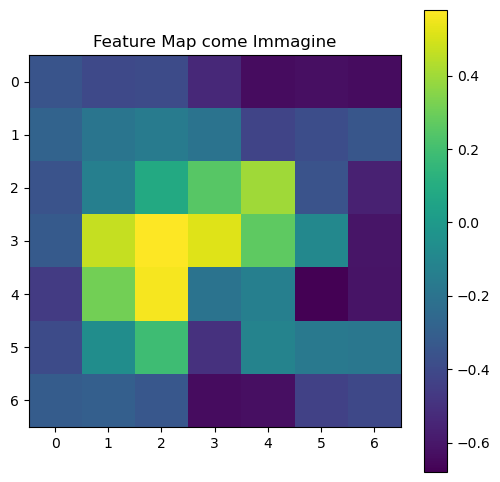

In [16]:
import matplotlib.pyplot as plt

print(features[0].shape)
print(features[1].shape)

# Selezioniamo una feature map specifica dal primo layer target
feature_map = features[1][0, :, :, 200]  # Prima feature map del primo layer

# 1. Visualizziamo la feature map come elenco di numeri
print("Feature Map (elenco di numeri):")
print(feature_map)

# 2. Visualizziamo la feature map come immagine
plt.figure(figsize=(6, 6))
plt.imshow(feature_map, cmap="viridis")  # Usando una colormap per una migliore visualizzazione
plt.title("Feature Map come Immagine")
plt.colorbar()
plt.show()


## Comprendere le differenze 

Questa immagine illustra la differenza tra l'output di una rete neurale completa e un feature extractor:

1. **Rete neurale completa** (prima parte del diagramma, in alto):
   - L'immagine di input (ad esempio, un elefante) passa attraverso vari livelli convoluzionali, pool e completamente connessi.
   - L'output è una previsione finale sotto forma di probabilità per diverse classi (es.: elefante, leone, ecc.).

2. **Feature Extractor** (seconda parte del diagramma, in basso):
   - L'immagine passa attraverso gli stessi livelli convoluzionali, ma si interrompe prima dei livelli completamente connessi.
   - L'output non è una previsione di classe, bensì le **feature maps** intermedie, che rappresentano le caratteristiche estratte dall'immagine.
   - Le feature maps sono matrici che codificano informazioni sulle parti e i pattern rilevanti dell'immagine.

<img src="assets/feature_extractor.drawio.png"/>
